In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, precision_recall_curve 

#leading to static images of your plot embedded in the notebook
%matplotlib inline
from matplotlib import pyplot as plt

import seaborn as sns

import time


# Reading the dataset

In [2]:
data = pd.read_csv('bank.csv', sep= ';')
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [3]:
data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


# Feature Engineering

# 1. Label Encoding the Binary Attributes

In [4]:
labels1 = ['housing', 'default', 'loan', 'y']
for label in labels1:
    le = LabelEncoder()
    le.fit(data[label])
    data[label] = le.transform(data[label])

In [5]:
#for one-hot encoding later
labels2 = ['job', 'contact', 'marital','education', 'poutcome', 'month']
for label in labels2:
    le = LabelEncoder()
    le.fit(data[label])
    data[label] = le.transform(data[label])

In [6]:
#checking whether LabelEncoder is used correctly
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,10,1,0,0,1787,0,0,0,19,10,79,1,-1,0,3,0
1,33,7,1,1,0,4789,1,1,0,11,8,220,1,339,4,0,0
2,35,4,2,2,0,1350,1,0,0,16,0,185,1,330,1,0,0
3,30,4,1,2,0,1476,1,1,2,3,6,199,4,-1,0,3,0
4,59,1,1,1,0,0,1,0,2,5,8,226,1,-1,0,3,0


# 2. Data Visualization

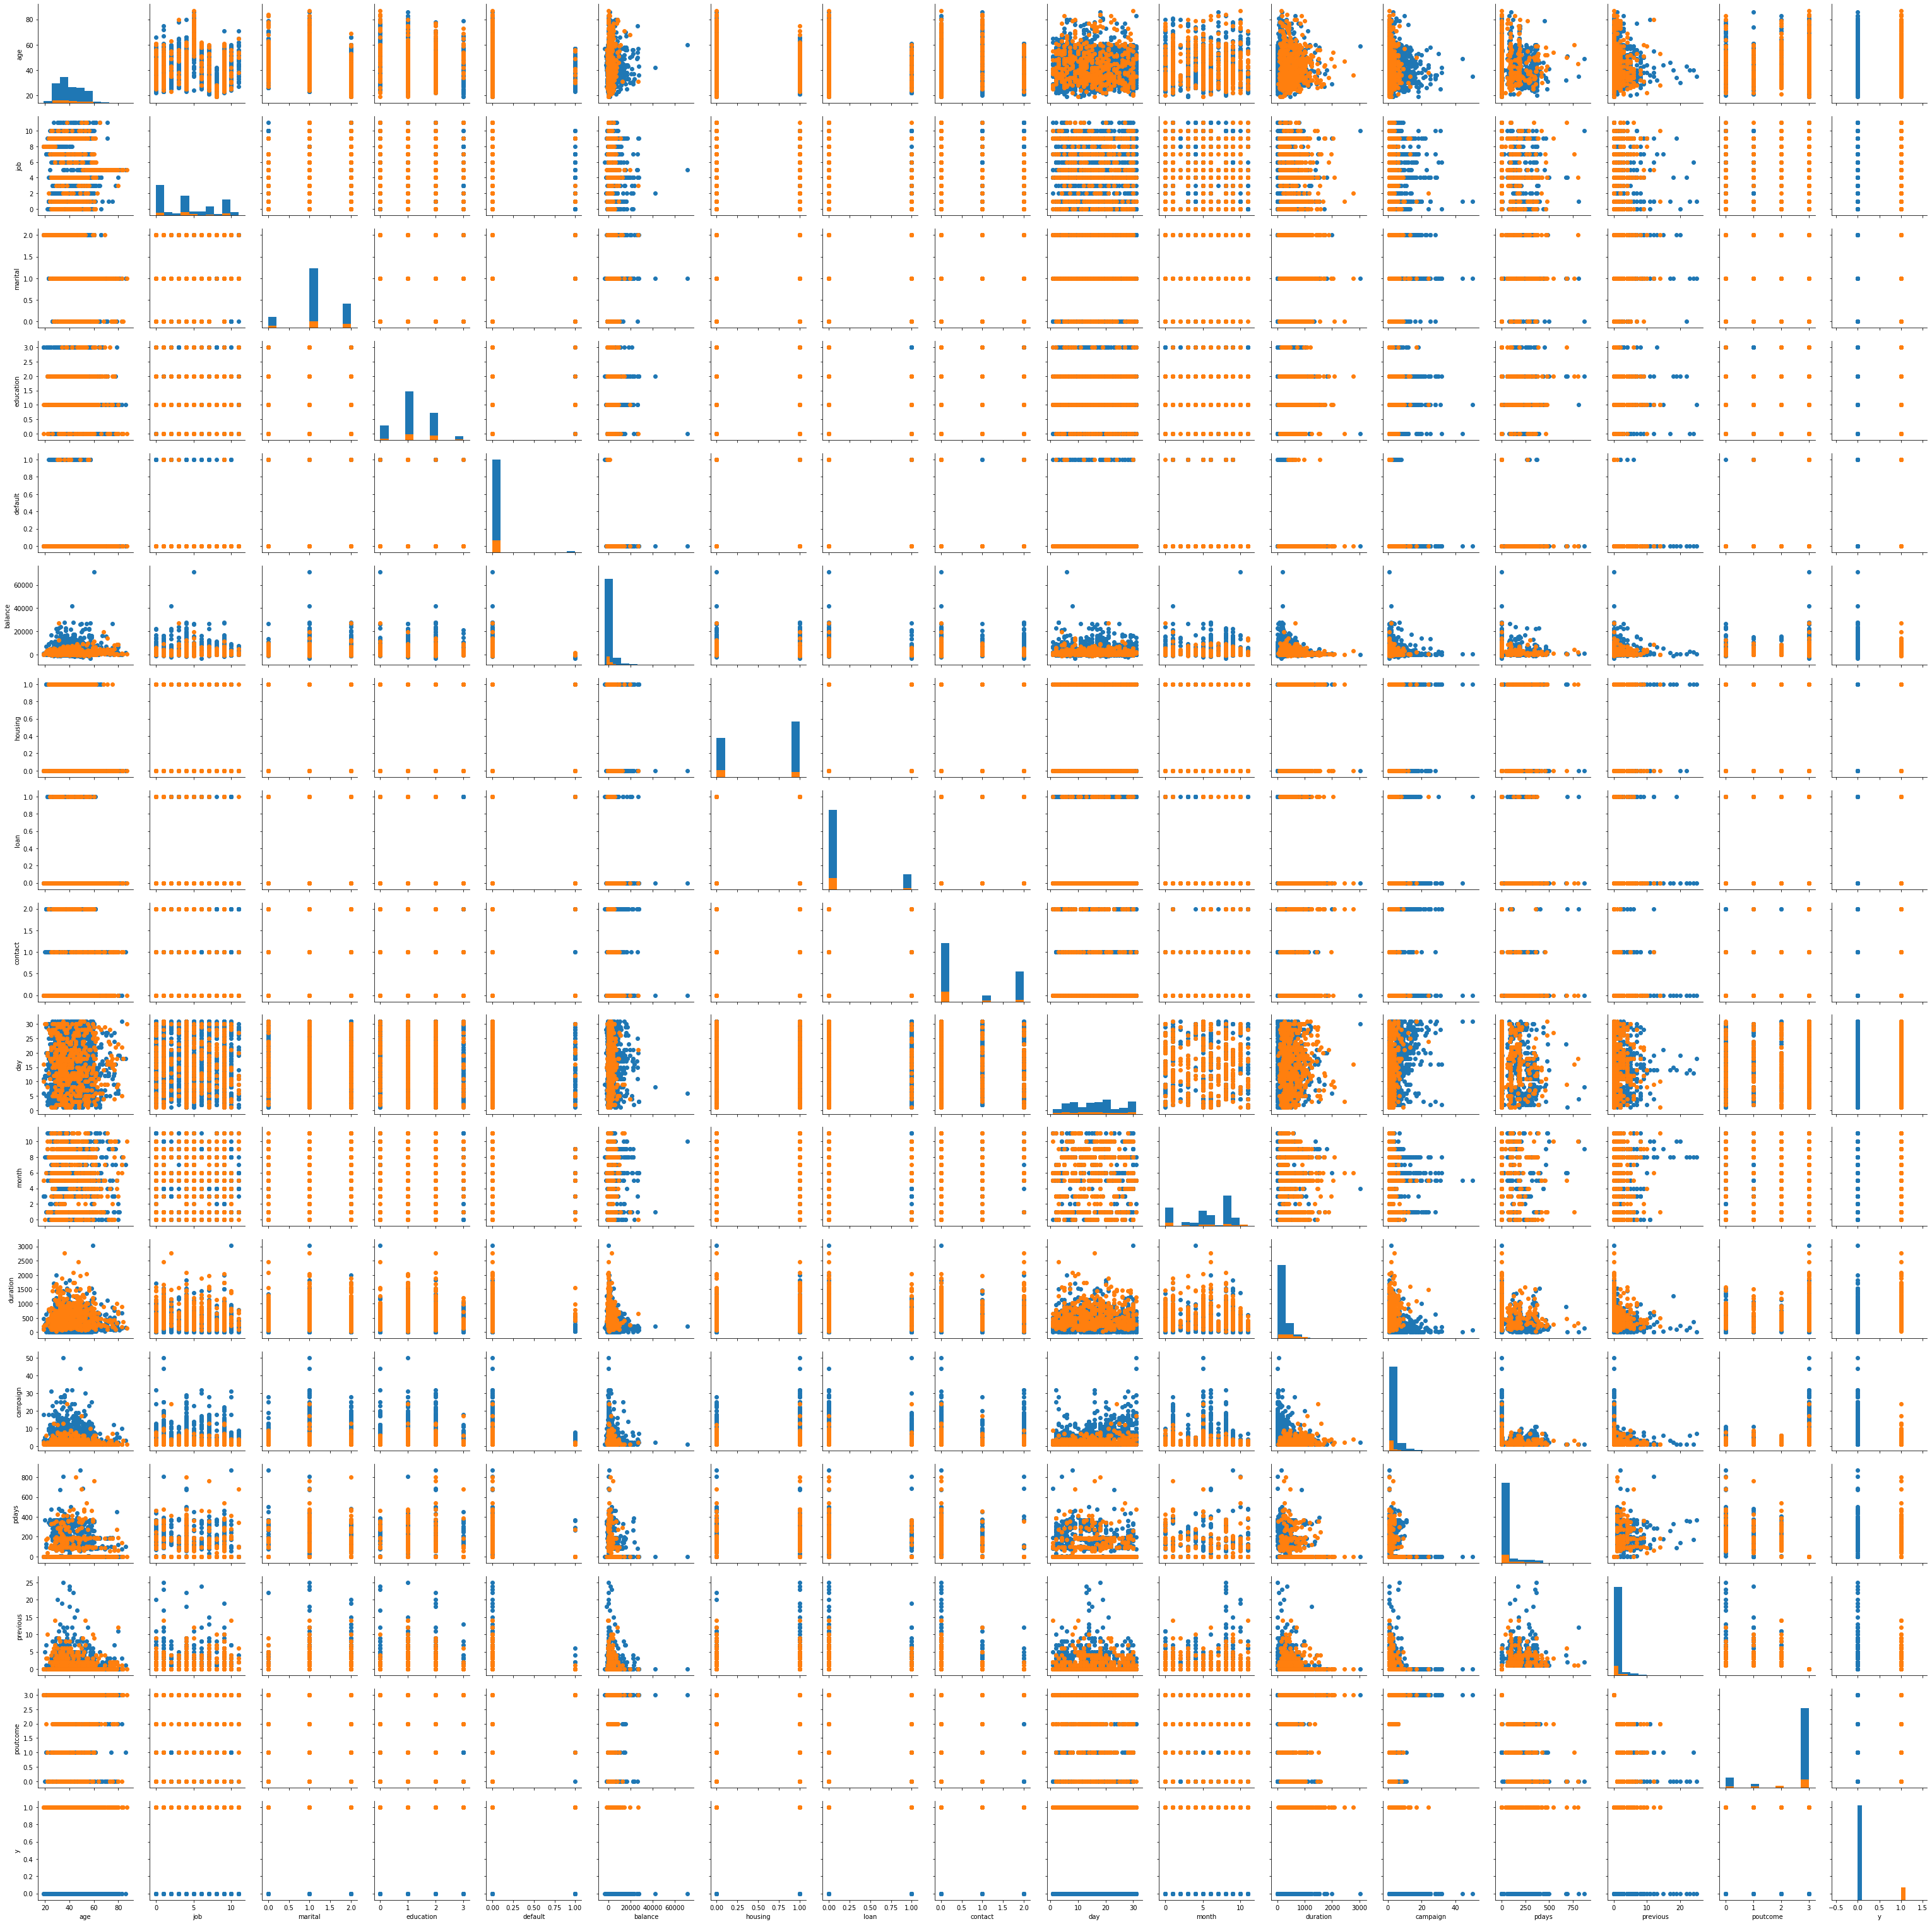

In [7]:
g=sns.PairGrid(data,hue='y')
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)

In [8]:
data_corr = data.corr()

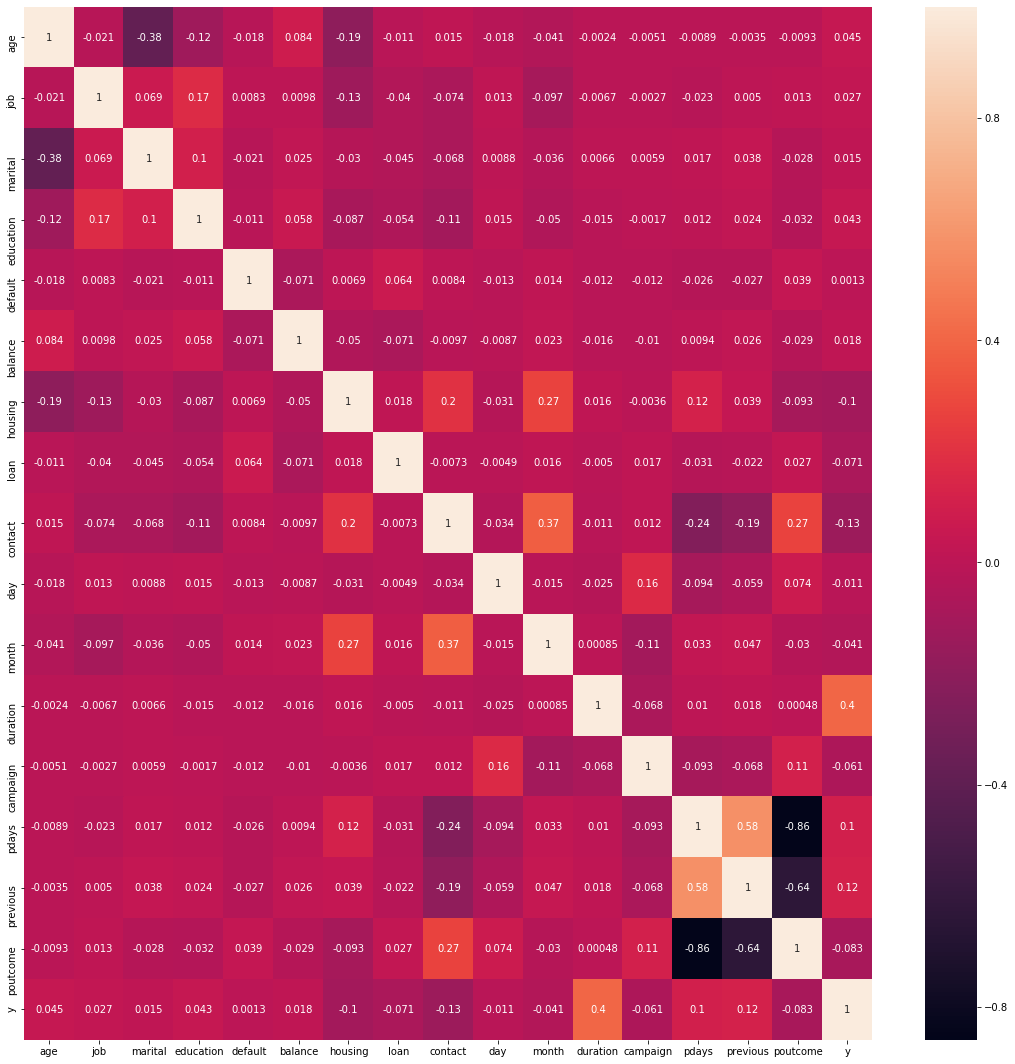

In [9]:
plt.figure(figsize=(19,19))
axes=sns.heatmap(data_corr, annot = True)
bottom, top = axes.get_ylim()
axes.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [10]:
data=data.drop(["pdays",'default'], axis=1)

# 3. Data Balance

In [11]:
#checking missing data
data.isnull().sum().sum()

0

In [12]:
# get 'day' involved in one hot encoding
labels2.append('day')

In [13]:
data = pd.get_dummies(data, columns = labels2)

In [14]:
#make the column-"y" become the last column
columns = data.columns.tolist()
columns.insert(columns.index('day_30')+1, columns.pop(columns.index('y')))

In [15]:
data = data[columns]
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,4521.0,41.170095,10.576211,19.0,33.0,39.0,49.0,87.0
balance,4521.0,1422.657819,3009.638142,-3313.0,69.0,444.0,1480.0,71188.0
housing,4521.0,0.566025,0.495676,0.0,0.0,1.0,1.0,1.0
loan,4521.0,0.152842,0.359875,0.0,0.0,0.0,0.0,1.0
duration,4521.0,263.961292,259.856633,4.0,104.0,185.0,329.0,3025.0
...,...,...,...,...,...,...,...,...
day_28,4521.0,0.040035,0.196064,0.0,0.0,0.0,0.0,1.0
day_29,4521.0,0.038708,0.192920,0.0,0.0,0.0,0.0,1.0
day_30,4521.0,0.037160,0.189174,0.0,0.0,0.0,0.0,1.0
day_31,4521.0,0.013050,0.113502,0.0,0.0,0.0,0.0,1.0


Ratio of classes (no : yes) 0.8847600088476001 : 0.11523999115239991


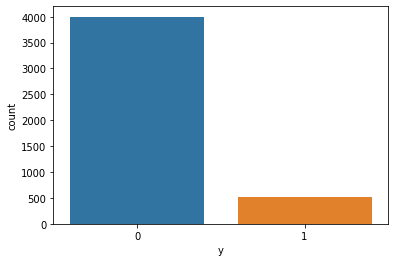

In [16]:
ratio = data.y[data.y == 1].count() / data.y.shape[0]
print('Ratio of classes (no : yes)', 1- ratio, ':', ratio)
sns.countplot(data.y)
plt.show()

In [17]:
print(data.y[data.y == 1].count())
print(data.y[data.y == 0].count())

521
4000


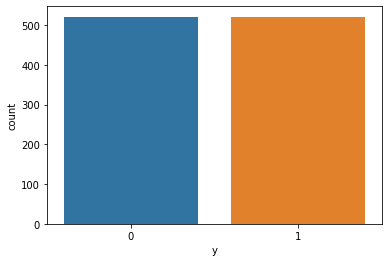

In [18]:
data_0 = data[data['y'] == 0]
data_1 = data[data['y'] == 1]
data_balanced  =data_0.sample(n=521, random_state=90)
data_balanced = data_balanced.append(data_1.sample(n=521, random_state=90))

sns.countplot(data_balanced['y'])

In [19]:
data_balanced = data_balanced.sort_index(ascending=True) 
data_balanced

,age,balance,housing,loan,duration,campaign,previous,job_0,job_1,job_2,...,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31,y
1,33,4789,1,1,220,1,4,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,35,747,0,0,141,2,3,0,0,0,...,1,0,0,0,0,0,0,0,0,0
12,36,1109,0,0,328,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,20,502,0,0,261,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
28,56,784,0,1,149,2,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4500,38,4196,1,0,193,2,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4503,60,362,0,1,816,6,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4504,42,1080,1,1,951,3,4,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4505,32,620,1,0,1234,3,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1



# 4. Data Normalization

In [20]:
scaler = MinMaxScaler()
features = pd.DataFrame(scaler.fit_transform(data_balanced.drop(['y'], axis = 1)), columns = data_balanced.drop(['y'], axis = 1).columns)
features

,age,balance,housing,loan,duration,campaign,previous,job_0,job_1,job_2,...,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31
0,0.205882,0.212025,1.0,1.0,0.077786,0.000000,0.20,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.235294,0.069072,0.0,0.0,0.049204,0.034483,0.15,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.250000,0.081874,0.0,0.0,0.116860,0.034483,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.014706,0.060407,0.0,0.0,0.092619,0.000000,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.544118,0.070380,0.0,1.0,0.052098,0.034483,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1037,0.279412,0.191052,1.0,0.0,0.068017,0.034483,0.00,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1038,0.602941,0.055455,0.0,1.0,0.293415,0.172414,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1039,0.338235,0.080849,1.0,1.0,0.342258,0.068966,0.20,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1040,0.191176,0.064580,1.0,0.0,0.444645,0.068966,0.00,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [21]:
features.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1042.0,0.334622,0.171189,0.0,0.205882,0.308824,0.441176,1.0
balance,1042.0,0.095449,0.091940,0.0,0.046676,0.062935,0.110707,1.0
housing,1042.0,0.500960,0.500239,0.0,0.000000,1.000000,1.000000,1.0
loan,1042.0,0.120921,0.326192,0.0,0.000000,0.000000,0.000000,1.0
duration,1042.0,0.139634,0.129139,0.0,0.050289,0.094971,0.188495,1.0
...,...,...,...,...,...,...,...,...
day_27,1042.0,0.026871,0.161785,0.0,0.000000,0.000000,0.000000,1.0
day_28,1042.0,0.037428,0.189899,0.0,0.000000,0.000000,0.000000,1.0
day_29,1042.0,0.030710,0.172614,0.0,0.000000,0.000000,0.000000,1.0
day_30,1042.0,0.047985,0.213836,0.0,0.000000,0.000000,0.000000,1.0


In [22]:
labels = data_balanced.y
labels

1       0
5       0
12      0
13      1
28      0
       ..
4500    0
4503    1
4504    1
4505    1
4511    1
Name: y, Length: 1042, dtype: int32

# Splitting data into training data and test data

In [23]:
data_train, data_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.3, random_state=90,stratify = labels)

In [24]:
data_train

,age,balance,housing,loan,duration,campaign,previous,job_0,job_1,job_2,...,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31
923,0.529412,0.081061,1.0,0.0,0.051013,0.000000,0.10,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
834,0.485294,0.045588,0.0,0.0,0.440666,0.172414,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
746,0.529412,0.052697,0.0,1.0,0.089363,0.103448,0.00,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
598,0.117647,0.172520,1.0,0.0,0.054993,0.034483,0.25,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
928,0.485294,0.121415,0.0,0.0,0.085745,0.034483,0.00,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,0.205882,0.045694,1.0,0.0,0.129884,0.000000,0.00,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
567,0.397059,0.063625,1.0,0.0,0.066932,0.068966,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
55,0.147059,0.059699,0.0,1.0,0.395080,0.068966,0.00,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
774,0.882353,0.057825,0.0,0.0,0.362156,0.034483,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Decision Tree

In [25]:
t0=time.time()
params = {
            "criterion" : ["gini", "entropy"], 
            "splitter" : ["best", "random"], 
            "max_depth" : [25, 50, 75, None],
            "min_samples_split" : [3, 6], 
            "min_samples_leaf" : [2, 4],  }
clfDT = GridSearchCV(estimator = DecisionTreeClassifier(random_state=90), param_grid = params, cv = 5,n_jobs = -1, iid=True, scoring = "accuracy")
clfDT.fit(data_train, labels_train)
trainingtime = pd.DataFrame(columns = ["Classifier", "Training Time(Seconds)"])
trainingtime.loc[0] = ["Decision Tree", round((time.time()-t0), 2)] 
trainingtime.index = trainingtime.index + 1


In [26]:


print(clfDT)
#key=operator.itemgetter(1),

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=90,
                                              splitter='best'),
             iid=True, n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [25, 50, 75, None],
                         

In [27]:
clfDT.best_score_

0.7530864197530864

In [28]:
clfDT.best_params_

{'criterion': 'entropy',
 'max_depth': 25,
 'min_samples_leaf': 4,
 'min_samples_split': 3,
 'splitter': 'best'}

In [29]:
clfDT1 = clfDT.best_estimator_
precisionDT = precision_score(labels_test, clfDT1.predict(data_test))
recallDT = recall_score(labels_test, clfDT1.predict(data_test))
f1DT = f1_score(labels_test, clfDT1.predict(data_test))
aucDT = roc_auc_score(labels_test, clfDT1.predict(data_test))
accDT = accuracy_score(labels_test, clfDT1.predict(data_test))

In [30]:
print("Precision on test data is: %f" %precisionDT)
print("Recall on test data is: %f" %recallDT)
print("F1-Score on test data is: %f" %f1DT)
print("Area under ROC on test data is: %f" %aucDT)
print("Accuracy on test data is: %f" %accDT)

testing = pd.DataFrame(columns = ["Classifier", "Precision", "Recall", "F1-Score", "AUC", "Accuracy"])
testing.loc[0] = ["Decision Tree", precisionDT, recallDT, f1DT, aucDT, accDT]
testing.index = testing.index + 1
testing = testing.sort_index()

Precision on test data is: 0.778523
Recall on test data is: 0.738854
F1-Score on test data is: 0.758170
Area under ROC on test data is: 0.763658
Accuracy on test data is: 0.763578


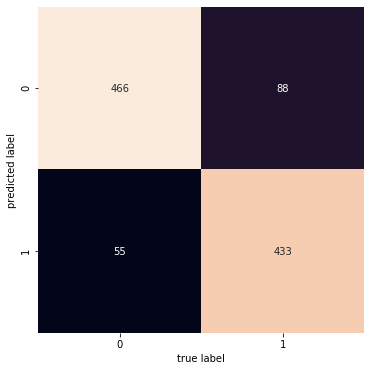

In [31]:
classes = pd.Series(labels).unique()
plt.figure(figsize=(6,6))
mat = confusion_matrix(labels, clfDT1.predict(features))
ax=sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=classes, yticklabels=classes)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.show()

In [32]:
print(classification_report(labels_test,clfDT1.predict(data_test)))

              precision    recall  f1-score   support

           0       0.75      0.79      0.77       156
           1       0.78      0.74      0.76       157

    accuracy                           0.76       313
   macro avg       0.76      0.76      0.76       313
weighted avg       0.76      0.76      0.76       313



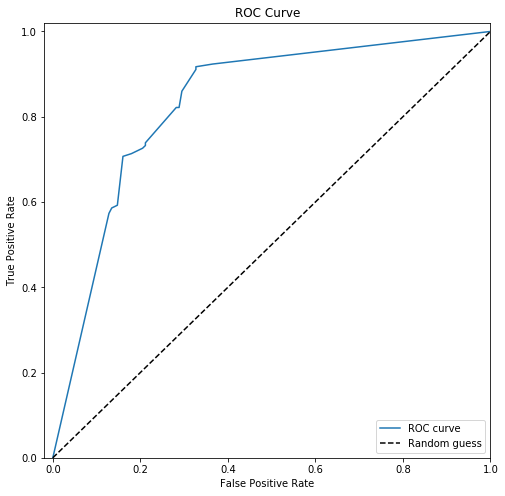

In [33]:
y_pred_prob = clfDT1.predict_proba(data_test)[:,1]

fpr, tpr, thresholds = roc_curve(labels_test, y_pred_prob)

# create plot
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")



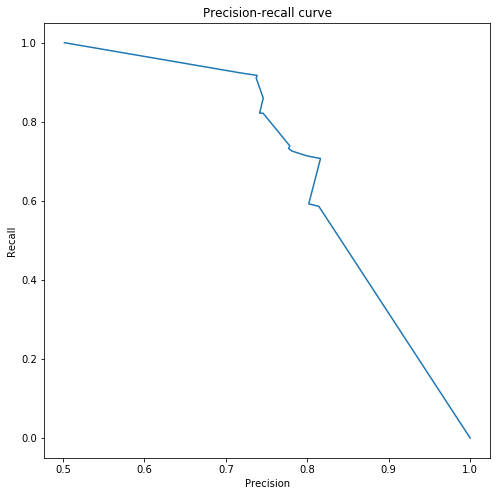

In [34]:
precision, recall, thresholds = precision_recall_curve(labels_test, y_pred_prob)

# create plot
plt.figure(figsize=(8,8))
plt.plot(precision, recall, label='Precision-recall curve')
_ = plt.xlabel('Precision')
_ = plt.ylabel('Recall')
_ = plt.title('Precision-recall curve')

# Random Forest

In [35]:

t0=time.time()
params = {
            "n_estimators" : [50,100,120,150,180,300],  
            "max_depth" : [10,30,50],
            "min_samples_leaf" : [2,4,6,8,10]}
clfRF = GridSearchCV(estimator = RandomForestClassifier(random_state=90),param_grid = params, cv = 5,n_jobs = -1, scoring = "accuracy")


clfRF.fit(data_train, labels_train)
trainingtime.loc[0] = ["Random Forest", round((time.time()-t0), 2)] 
trainingtime.index = trainingtime.index + 1
print(clfRF)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=90,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'ma

In [36]:
clfRF.best_score_

0.8052126200274349

In [37]:
clfRF.best_params_

{'max_depth': 30, 'min_samples_leaf': 2, 'n_estimators': 50}

In [38]:
clfRF1 = clfRF.best_estimator_
precisionRF = precision_score(labels_test, clfRF1.predict(data_test))
recallRF = recall_score(labels_test, clfRF1.predict(data_test))
f1RF = f1_score(labels_test, clfRF1.predict(data_test))
aucRF = roc_auc_score(labels_test, clfRF1.predict(data_test))
accRF = accuracy_score(labels_test, clfRF1.predict(data_test))

In [39]:
print("Precision on test data is: %f" %precisionRF)
print("Recall on test data is: %f" %recallRF)
print("F1-Score on test data is: %f" %f1RF)
print("Area under ROC on test data is: %f" %aucRF)
print("Accuracy on test data is: %f" %accRF)

testing.loc[0] = ["Random Forest", precisionRF, recallRF, f1RF, aucRF, accRF]
testing.index = testing.index + 1
testing = testing.sort_index()

Precision on test data is: 0.755556
Recall on test data is: 0.866242
F1-Score on test data is: 0.807122
Area under ROC on test data is: 0.792095
Accuracy on test data is: 0.792332


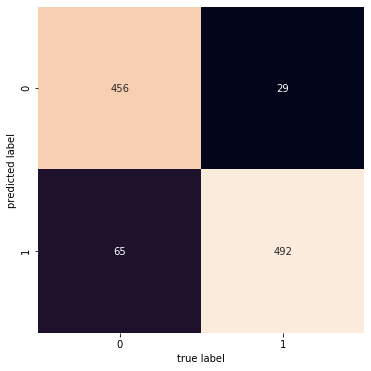

In [40]:
classes = pd.Series(labels).unique()
plt.figure(figsize=(6,6))
mat = confusion_matrix(labels, clfRF1.predict(features))
ax=sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=classes, yticklabels=classes)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.show()

In [41]:
print(classification_report(labels_test,clfRF1.predict(data_test)))

              precision    recall  f1-score   support

           0       0.84      0.72      0.78       156
           1       0.76      0.87      0.81       157

    accuracy                           0.79       313
   macro avg       0.80      0.79      0.79       313
weighted avg       0.80      0.79      0.79       313



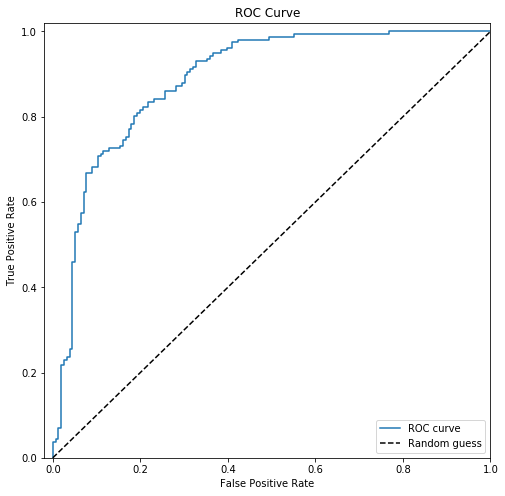

In [42]:
y_pred_prob = clfRF1.predict_proba(data_test)[:,1]

fpr, tpr, thresholds = roc_curve(labels_test, y_pred_prob)

# create plot
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")


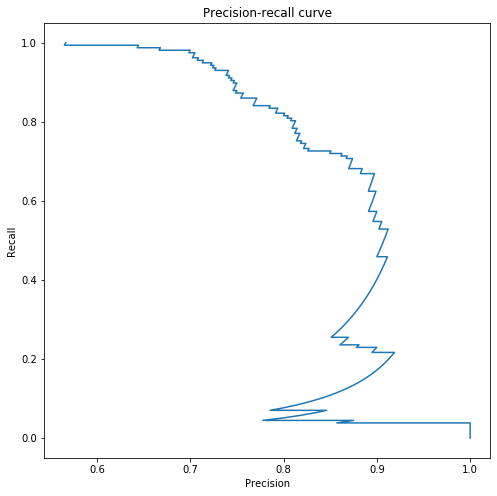

In [43]:
precision, recall, thresholds = precision_recall_curve(labels_test, y_pred_prob)

# create plot
plt.figure(figsize=(8,8))
plt.plot(precision, recall, label='Precision-recall curve')
_ = plt.xlabel('Precision')
_ = plt.ylabel('Recall')
_ = plt.title('Precision-recall curve')


# Gussian Naive Bayes

In [44]:
t0=time.time()
params = {}
clfGNB = GridSearchCV(estimator = GaussianNB(), param_grid = params, cv = 5, n_jobs = -1, scoring = "accuracy")
clfGNB.fit(data_train, labels_train)
trainingtime.loc[0] = ["Gussian Naive Bayes", round((time.time()-t0), 2)] 
trainingtime.index = trainingtime.index + 1
print(clfGNB)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e-09), iid='warn',
             n_jobs=-1, param_grid={}, pre_dispatch='2*n_jobs', refit=True,
             return_train_score=False, scoring='accuracy', verbose=0)


In [45]:
clfGNB.best_score_

0.5624142661179699

In [46]:
clfGNB1 = clfGNB.best_estimator_
precisionGNB = precision_score(labels_test, clfGNB1.predict(data_test))
recallGNB = recall_score(labels_test, clfGNB1.predict(data_test))
f1GNB = f1_score(labels_test, clfGNB1.predict(data_test))
aucGNB = roc_auc_score(labels_test, clfGNB1.predict(data_test))
accGNB = accuracy_score(labels_test, clfGNB1.predict(data_test))

In [47]:
print("F1-Score on test data is :%f" %f1GNB)
print("Area under ROC on test data is %f:" %aucGNB)
print("Accuracy on test data is %f :" %accGNB)


print("Precision on test data is: %f" %precisionGNB)
print("Recall on test data is: %f" %recallGNB)
print("F1-Score on test data is: %f" %f1GNB)
print("Area under ROC on test data is: %f" %aucGNB)
print("Accuracy on test data is: %f" %accGNB)

testing.loc[0] = ["Gussian Naive Bayes",precisionGNB, recallGNB, f1GNB, aucGNB, accGNB]
testing.index = testing.index + 1
testing = testing.sort_index()

F1-Score on test data is :0.322917
Area under ROC on test data is 0.585906:
Accuracy on test data is 0.584665 :
Precision on test data is: 0.885714
Recall on test data is: 0.197452
F1-Score on test data is: 0.322917
Area under ROC on test data is: 0.585906
Accuracy on test data is: 0.584665


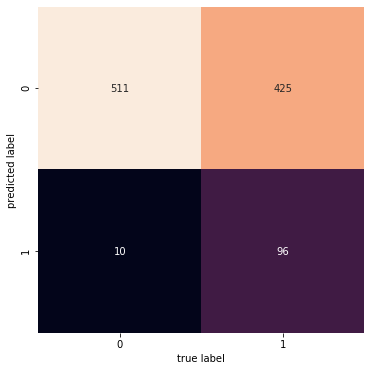

In [48]:
classes = pd.Series(labels).unique()
plt.figure(figsize=(6,6))
mat = confusion_matrix(labels, clfGNB1.predict(features))
ax=sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=classes, yticklabels=classes)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [49]:
print(classification_report(labels_test,clfGNB1.predict(data_test)))

              precision    recall  f1-score   support

           0       0.55      0.97      0.70       156
           1       0.89      0.20      0.32       157

    accuracy                           0.58       313
   macro avg       0.72      0.59      0.51       313
weighted avg       0.72      0.58      0.51       313



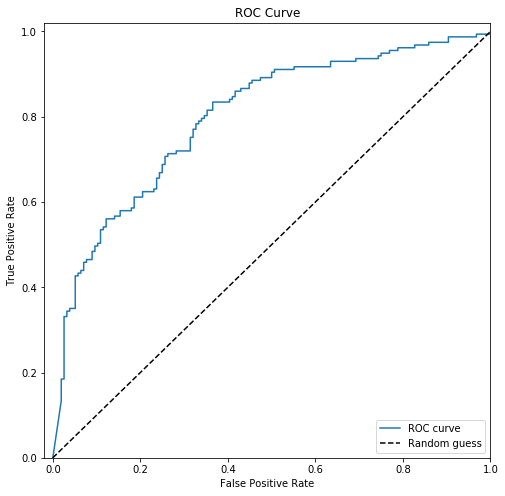

In [50]:
y_pred_prob = clfGNB1.predict_proba(data_test)[:,1]

fpr, tpr, thresholds = roc_curve(labels_test, y_pred_prob)

# create plot
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")

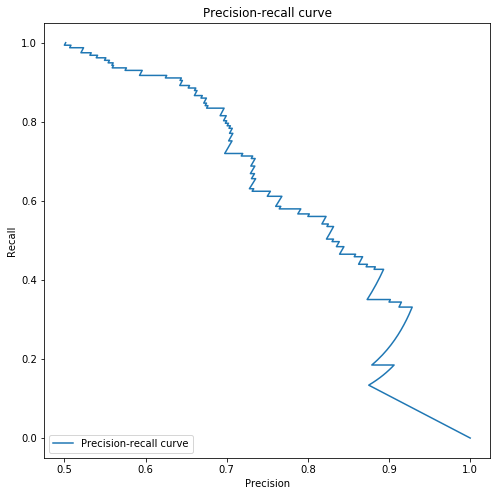

In [51]:
precision, recall, thresholds = precision_recall_curve(labels_test, y_pred_prob)
# create plot
plt.figure(figsize=(8,8))
plt.plot(precision, recall, label='Precision-recall curve')
_ = plt.xlabel('Precision')
_ = plt.ylabel('Recall')
_ = plt.title('Precision-recall curve')
_ = plt.legend(loc="lower left")

# Multinomial Naive Bayes

In [52]:
t0=time.time()
params={ 
            "alpha": [0.01,0.1,1],
            "fit_prior": [True, False] 
             }
clfMNB = GridSearchCV(estimator = MultinomialNB(), param_grid = params, cv = 5, n_jobs = -1, scoring = "accuracy")
clfMNB.fit(data_train, labels_train)
trainingtime.loc[0] = ["Multinomial Naive Bayes", round((time.time()-t0), 2)] 
trainingtime.index = trainingtime.index + 1

print(clfMNB)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [0.01, 0.1, 1], 'fit_prior': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)


In [53]:
clfMNB.best_params_

{'alpha': 0.1, 'fit_prior': False}

In [54]:
clfMNB.best_score_

0.6241426611796982

In [55]:
clfMNB1 = clfMNB.best_estimator_
precisionMNB = precision_score(labels_test, clfMNB1.predict(data_test))
recallMNB = recall_score(labels_test, clfMNB1.predict(data_test))
f1MNB = f1_score(labels_test, clfMNB1.predict(data_test))
aucMNB = roc_auc_score(labels_test, clfMNB1.predict(data_test))
accMNB = accuracy_score(labels_test, clfMNB1.predict(data_test))

In [56]:
print("Precision on test data is: %f" %precisionMNB)
print("Recall on test data is: %f" %recallMNB)
print("F1-Score on test data is: %f" %f1MNB)
print("Area under ROC on test data is: %f" %aucMNB)
print("Accuracy on test data is: %f" %accMNB)

testing.loc[0] = ["Multinomial Naive Bayes", precisionMNB, recallMNB, f1MNB, aucMNB, accMNB]
testing.index = testing.index + 1
testing = testing.sort_index()

Precision on test data is: 0.763514
Recall on test data is: 0.719745
F1-Score on test data is: 0.740984
Area under ROC on test data is: 0.747693
Accuracy on test data is: 0.747604


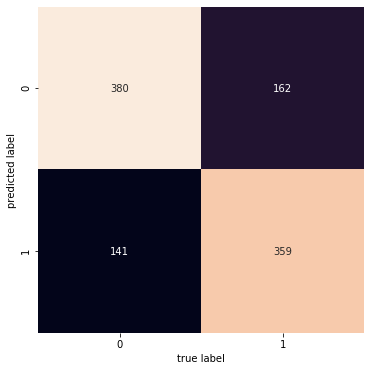

In [57]:
classes = pd.Series(labels).unique()
plt.figure(figsize=(6,6))
mat = confusion_matrix(labels, clfMNB1.predict(features))
ax=sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=classes, yticklabels=classes)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.show()

In [58]:
print(classification_report(labels_test,clfMNB1.predict(data_test)))

              precision    recall  f1-score   support

           0       0.73      0.78      0.75       156
           1       0.76      0.72      0.74       157

    accuracy                           0.75       313
   macro avg       0.75      0.75      0.75       313
weighted avg       0.75      0.75      0.75       313



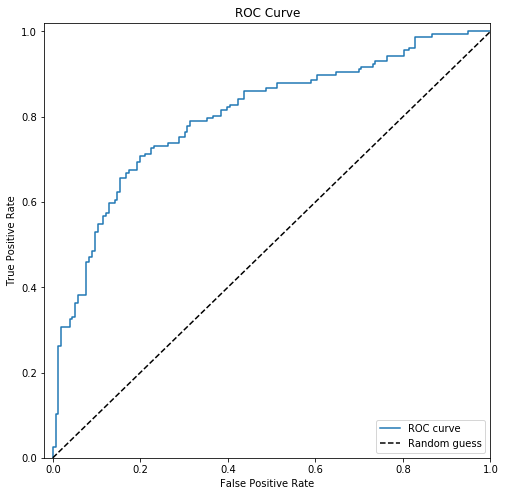

In [59]:
y_pred_prob = clfMNB1.predict_proba(data_test)[:,1]

fpr, tpr, thresholds = roc_curve(labels_test, y_pred_prob)

# create plot
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")

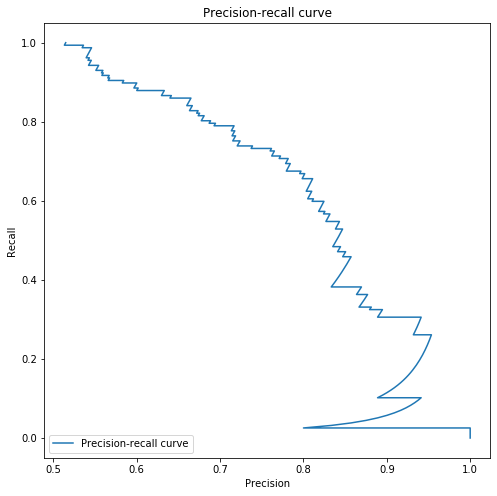

In [60]:
precision, recall, thresholds = precision_recall_curve(labels_test, y_pred_prob)

# create plot
plt.figure(figsize=(8,8))
plt.plot(precision, recall, label='Precision-recall curve')
_ = plt.xlabel('Precision')
_ = plt.ylabel('Recall')
_ = plt.title('Precision-recall curve')
_ = plt.legend(loc="lower left")

# Support Vector Machine-Linear

In [61]:
t0=time.time()
parameters = {"C": [0.005, 0.1, 1, 5, 10], "kernel": ["linear"]
              }
clfSVClinear = GridSearchCV(SVC(probability=True), param_grid=parameters, scoring="accuracy", iid=True, n_jobs=-1, cv=5)
clfSVClinear.fit(data_train, labels_train)
trainingtime.loc[0] = ["Support Vector Machine-linear", round((time.time()-t0), 2)] 
trainingtime.index = trainingtime.index + 1

print(clfSVClinear)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=True, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid=True, n_jobs=-1,
             param_grid={'C': [0.005, 0.1, 1, 5, 10], 'kernel': ['linear']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)


In [62]:
print(clfSVClinear.best_params_)
print(clfSVClinear.cv_results_['mean_test_score'])
print(clfSVClinear.best_score_)
pd.set_option('display.width', 5000, 'display.max_rows', 75)
pd.DataFrame(clfSVClinear.cv_results_)


{'C': 10, 'kernel': 'linear'}
[0.62002743 0.70233196 0.7558299  0.76954733 0.77091907]
0.7709190672153635


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.154382,0.002477,0.008976,1.410773e-03,0.005,linear,"{'C': 0.005, 'kernel': 'linear'}",0.678082,0.602740,0.616438,0.616438,0.586207,0.620027,0.031105,5
1,0.138430,0.005795,0.007181,9.771456e-04,0.1,linear,"{'C': 0.1, 'kernel': 'linear'}",0.732877,0.684932,0.732877,0.636986,0.724138,0.702332,0.037204,4
2,0.162964,0.019448,0.005984,7.168434e-07,1,linear,"{'C': 1, 'kernel': 'linear'}",0.801370,0.760274,0.739726,0.719178,0.758621,0.755830,0.027237,3
3,0.296406,0.009322,0.003790,7.463913e-04,5,linear,"{'C': 5, 'kernel': 'linear'}",0.787671,0.780822,0.767123,0.739726,0.772414,0.769547,0.016497,2
4,0.405143,0.040083,0.003012,1.955067e-05,10,linear,"{'C': 10, 'kernel': 'linear'}",0.801370,0.780822,0.767123,0.719178,0.786207,0.770919,0.028123,1


In [63]:
clfSVClinear1 = clfSVClinear.best_estimator_
precisionSVClinear = precision_score(labels_test, clfSVClinear1.predict(data_test))
recallSVClinear = recall_score(labels_test, clfSVClinear1.predict(data_test))
f1SVClinear = f1_score(labels_test, clfSVClinear1.predict(data_test))
aucSVClinear = roc_auc_score(labels_test, clfSVClinear1.predict(data_test))
accSVClinear = accuracy_score(labels_test, clfSVClinear1.predict(data_test))

In [64]:
print("Precision on test data is: %f" %precisionSVClinear)
print("Recall on test data is: %f" %recallSVClinear)
print("F1-Score on test data is: %f" %f1SVClinear)
print("Area under ROC on test data is: %f" %aucSVClinear)
print("Accuracy on test data is: %f" %accSVClinear)

testing.loc[0] = ["Support Vector Machine-linear", precisionSVClinear, recallSVClinear, f1SVClinear, aucSVClinear, accSVClinear]
testing.index = testing.index + 1
testing = testing.sort_index()

Precision on test data is: 0.833333
Recall on test data is: 0.828025
F1-Score on test data is: 0.830671
Area under ROC on test data is: 0.830679
Accuracy on test data is: 0.830671


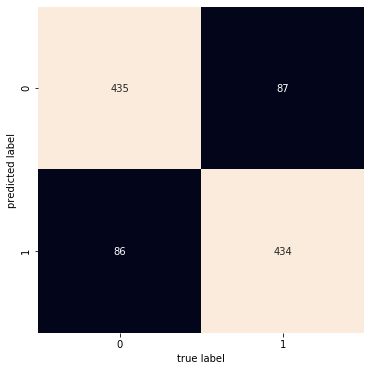

In [65]:
classes = pd.Series(labels).unique()
plt.figure(figsize=(6,6))
mat = confusion_matrix(labels, clfSVClinear1.predict(features))
ax=sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=classes, yticklabels=classes)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.show()

In [66]:
print(classification_report(labels_test, clfSVClinear1.predict(data_test)))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83       156
           1       0.83      0.83      0.83       157

    accuracy                           0.83       313
   macro avg       0.83      0.83      0.83       313
weighted avg       0.83      0.83      0.83       313



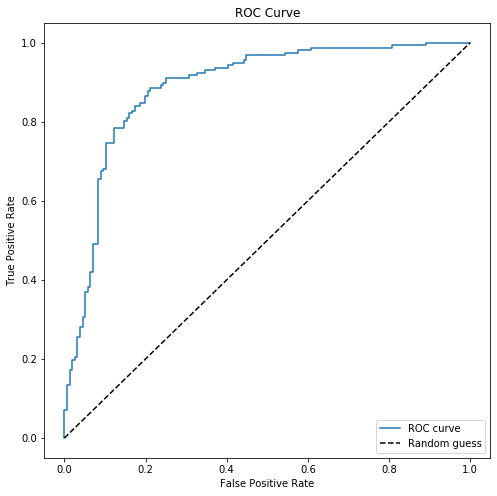

In [67]:
y_pred_prob = clfSVClinear1.predict_proba(data_test)[:,1]

fpr, tpr, thresholds = roc_curve(labels_test, y_pred_prob)

# create plot
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')

_ = plt.legend(loc="lower right")

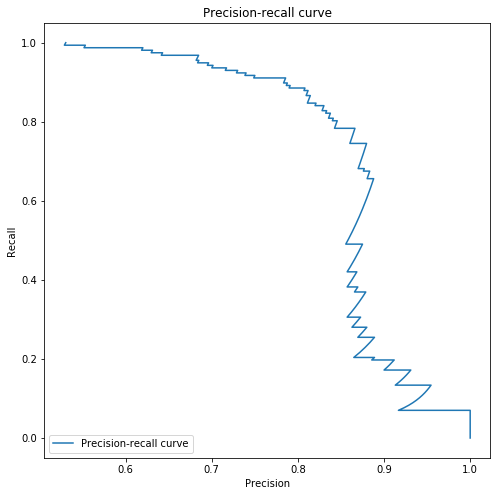

In [68]:
y_pred_prob = clfSVClinear1.predict_proba(data_test)[:,1]

precision, recall, thresholds = precision_recall_curve(labels_test, y_pred_prob)

# create plot
plt.figure(figsize=(8, 8))
plt.plot(precision, recall, label='Precision-recall curve')
_ = plt.xlabel('Precision')
_ = plt.ylabel('Recall')
_ = plt.title('Precision-recall curve')

_ = plt.legend(loc="lower left")

# Support Vector Machine-rbf

In [69]:
t0=time.time()
parameters =   {"C": [0.005, 0.1, 1, 5, 10],"kernel": ["rbf"],
               "gamma": [0.0001, 0.001, 0.005, 0.1, 1, 3, 5]}
clfSVCrbf = GridSearchCV(SVC(probability=True), param_grid=parameters, scoring="accuracy", iid=True, n_jobs=-1, cv=5)
clfSVCrbf.fit(data_train, labels_train)
trainingtime.loc[0] = ["Support Vector Machine-rbf", round((time.time()-t0), 2)] 
trainingtime.index = trainingtime.index + 1

print(clfSVCrbf)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=True, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid=True, n_jobs=-1,
             param_grid={'C': [0.005, 0.1, 1, 5, 10],
                         'gamma': [0.0001, 0.001, 0.005, 0.1, 1, 3, 5],
                         'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)


In [70]:
print(clfSVCrbf.best_params_)
print(clfSVCrbf.cv_results_['mean_test_score'])
print(clfSVCrbf.best_score_)
pd.set_option('display.width', 5000, 'display.max_rows', 75)
pd.DataFrame(clfSVCrbf.cv_results_)

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
[0.51851852 0.51851852 0.51851852 0.51851852 0.51714678 0.49794239
 0.49931413 0.51851852 0.51851852 0.51851852 0.61179698 0.51714678
 0.49794239 0.49931413 0.51851852 0.51851852 0.61728395 0.68449931
 0.59533608 0.50891632 0.50068587 0.51851852 0.61865569 0.65569273
 0.7133059  0.59533608 0.52674897 0.50205761 0.51851852 0.63374486
 0.70096022 0.71879287 0.59670782 0.52537723 0.50205761]
0.7187928669410151


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.193275,0.009223,0.010372,4.886949e-04,0.005,0.0001,rbf,"{'C': 0.005, 'gamma': 0.0001, 'kernel': 'rbf'}",0.500000,0.500000,0.500000,0.500000,0.593103,0.518519,0.037165,15
1,0.211035,0.013914,0.014362,7.792331e-03,0.005,0.001,rbf,"{'C': 0.005, 'gamma': 0.001, 'kernel': 'rbf'}",0.500000,0.500000,0.500000,0.500000,0.593103,0.518519,0.037165,15
2,0.202458,0.014048,0.010372,1.352388e-03,0.005,0.005,rbf,"{'C': 0.005, 'gamma': 0.005, 'kernel': 'rbf'}",0.500000,0.500000,0.500000,0.500000,0.593103,0.518519,0.037165,15
3,0.207245,0.009921,0.009973,5.135693e-07,0.005,0.1,rbf,"{'C': 0.005, 'gamma': 0.1, 'kernel': 'rbf'}",0.500000,0.500000,0.500000,0.500000,0.593103,0.518519,0.037165,15
4,0.202857,0.001621,0.009974,6.309021e-04,0.005,1,rbf,"{'C': 0.005, 'gamma': 1, 'kernel': 'rbf'}",0.500000,0.500000,0.500000,0.500000,0.586207,0.517147,0.034412,26
5,0.205849,0.013419,0.010971,1.784353e-03,0.005,3,rbf,"{'C': 0.005, 'gamma': 3, 'kernel': 'rbf'}",0.500000,0.500000,0.500000,0.500000,0.489655,0.497942,0.004129,34
6,0.203655,0.004250,0.010373,1.017645e-03,0.005,5,rbf,"{'C': 0.005, 'gamma': 5, 'kernel': 'rbf'}",0.500000,0.500000,0.500000,0.500000,0.496552,0.499314,0.001376,32
7,0.200662,0.012511,0.009774,3.988267e-04,0.1,0.0001,rbf,"{'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}",0.500000,0.500000,0.500000,0.500000,0.593103,0.518519,0.037165,15
8,0.200862,0.006358,0.009974,6.306758e-04,0.1,0.001,rbf,"{'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}",0.500000,0.500000,0.500000,0.500000,0.593103,0.518519,0.037165,15
9,0.200264,0.006064,0.010372,1.017055e-03,0.1,0.005,rbf,"{'C': 0.1, 'gamma': 0.005, 'kernel': 'rbf'}",0.500000,0.500000,0.500000,0.500000,0.593103,0.518519,0.037165,15


In [71]:
clfSVCrbf1 = clfSVCrbf.best_estimator_
precisionSVCrbf = precision_score(labels_test, clfSVCrbf1.predict(data_test))
recallSVCrbf = recall_score(labels_test, clfSVCrbf1.predict(data_test))
f1SVCrbf = f1_score(labels_test, clfSVCrbf1.predict(data_test))
aucSVCrbf = roc_auc_score(labels_test, clfSVCrbf1.predict(data_test))
accSVCrbf = accuracy_score(labels_test, clfSVCrbf1.predict(data_test))

In [72]:
print("Precision on test data is: %f" %precisionSVCrbf)
print("Recall on test data is: %f" %recallSVCrbf)
print("F1-Score on test data is: %f" %f1SVCrbf)
print("Area under ROC on test data is: %f" %aucSVCrbf)
print("Accuracy on test data is: %f" %accSVCrbf)

testing.loc[0] = ["Support Vector Machine-rbf", precisionSVCrbf, recallSVCrbf, f1SVCrbf, aucSVCrbf, accSVCrbf]
testing.index = testing.index + 1
testing = testing.sort_index()

Precision on test data is: 0.775758
Recall on test data is: 0.815287
F1-Score on test data is: 0.795031
Area under ROC on test data is: 0.789054
Accuracy on test data is: 0.789137


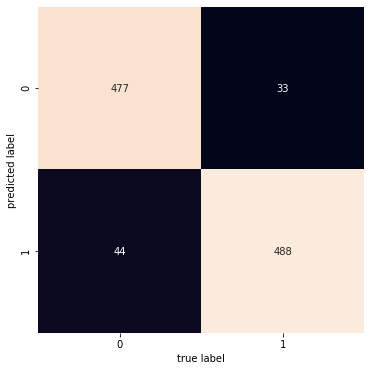

In [73]:
classes = pd.Series(labels).unique()
plt.figure(figsize=(6,6))
mat = confusion_matrix(labels, clfSVCrbf1.predict(features))
ax=sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=classes, yticklabels=classes)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.show()

In [74]:
print(classification_report(labels_test, clfSVCrbf1.predict(data_test)))

              precision    recall  f1-score   support

           0       0.80      0.76      0.78       156
           1       0.78      0.82      0.80       157

    accuracy                           0.79       313
   macro avg       0.79      0.79      0.79       313
weighted avg       0.79      0.79      0.79       313



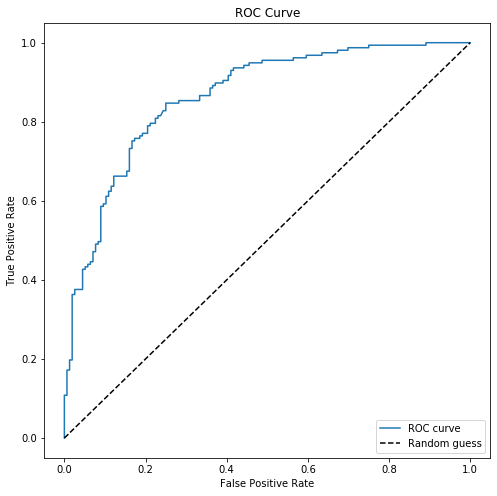

In [75]:
y_pred_prob = clfSVCrbf1.predict_proba(data_test)[:,1]

fpr, tpr, thresholds = roc_curve(labels_test, y_pred_prob)

# create plot
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')

_ = plt.legend(loc="lower right")

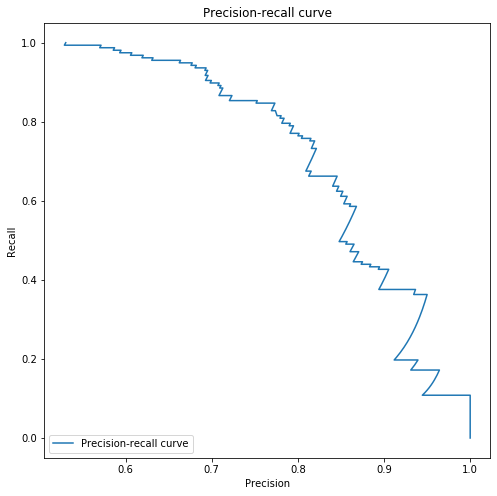

In [76]:
y_pred_prob = clfSVCrbf1.predict_proba(data_test)[:,1]

precision, recall, thresholds = precision_recall_curve(labels_test, y_pred_prob)

# create plot
plt.figure(figsize=(8, 8))
plt.plot(precision, recall, label='Precision-recall curve')
_ = plt.xlabel('Precision')
_ = plt.ylabel('Recall')
_ = plt.title('Precision-recall curve')

_ = plt.legend(loc="lower left")

# Support Vector Machine-poly

In [77]:
t0=time.time()
parameters =  {"C":  [0.005,0.1, 1, 5, 10], "kernel":["poly"],
               "gamma": [0.0001, 0.001, 0.005, 0.1, 1, 3, 5]}
clfSVCpoly = GridSearchCV(SVC(probability=True), param_grid=parameters, scoring="accuracy", iid=True, n_jobs=-1, cv=5)
clfSVCpoly.fit(data_train, labels_train)
trainingtime.loc[0] = ["Support Vector Machine-poly", round((time.time()-t0), 2)] 
trainingtime.index = trainingtime.index + 1

print(clfSVCpoly)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=True, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid=True, n_jobs=-1,
             param_grid={'C': [0.005, 0.1, 1, 5, 10],
                         'gamma': [0.0001, 0.001, 0.005, 0.1, 1, 3, 5],
                         'kernel': ['poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)


In [78]:
print(clfSVCpoly.best_params_)
print(clfSVCpoly.cv_results_['mean_test_score'])
print(clfSVCpoly.best_score_)
pd.set_option('display.width', 5000, 'display.max_rows', 75)
pd.DataFrame(clfSVCpoly.cv_results_)

{'C': 0.005, 'gamma': 5, 'kernel': 'poly'}
[0.51028807 0.51028807 0.51028807 0.51028807 0.6872428  0.69821674
 0.70919067 0.51028807 0.51028807 0.51028807 0.58710562 0.69272977
 0.70919067 0.70919067 0.51028807 0.51028807 0.51028807 0.65294925
 0.70919067 0.70919067 0.70919067 0.51028807 0.51028807 0.51028807
 0.6872428  0.70919067 0.70919067 0.70919067 0.51028807 0.51028807
 0.51028807 0.67901235 0.70919067 0.70919067 0.70919067]
0.7091906721536351


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.162964,0.003816,0.008776,1.595855e-03,0.005,0.0001,poly,"{'C': 0.005, 'gamma': 0.0001, 'kernel': 'poly'}",0.500000,0.500000,0.500000,0.500000,0.551724,0.510288,0.020647,20
1,0.165158,0.003763,0.008976,6.304494e-04,0.005,0.001,poly,"{'C': 0.005, 'gamma': 0.001, 'kernel': 'poly'}",0.500000,0.500000,0.500000,0.500000,0.551724,0.510288,0.020647,20
2,0.164958,0.003489,0.008777,1.162525e-03,0.005,0.005,poly,"{'C': 0.005, 'gamma': 0.005, 'kernel': 'poly'}",0.500000,0.500000,0.500000,0.500000,0.551724,0.510288,0.020647,20
3,0.173337,0.007500,0.008976,6.296967e-04,0.005,0.1,poly,"{'C': 0.005, 'gamma': 0.1, 'kernel': 'poly'}",0.500000,0.500000,0.500000,0.500000,0.551724,0.510288,0.020647,20
4,0.190290,0.005622,0.009574,1.849787e-03,0.005,1,poly,"{'C': 0.005, 'gamma': 1, 'kernel': 'poly'}",0.657534,0.691781,0.698630,0.726027,0.662069,0.687243,0.025183,15
5,0.205849,0.006390,0.006782,3.995664e-04,0.005,3,poly,"{'C': 0.005, 'gamma': 3, 'kernel': 'poly'}",0.657534,0.684932,0.753425,0.726027,0.668966,0.698217,0.036088,13
6,0.199067,0.003489,0.006982,6.843901e-07,0.005,5,poly,"{'C': 0.005, 'gamma': 5, 'kernel': 'poly'}",0.657534,0.684932,0.746575,0.753425,0.703448,0.709191,0.036477,1
7,0.175331,0.004478,0.008776,7.462892e-04,0.1,0.0001,poly,"{'C': 0.1, 'gamma': 0.0001, 'kernel': 'poly'}",0.500000,0.500000,0.500000,0.500000,0.551724,0.510288,0.020647,20
8,0.174733,0.004433,0.008976,6.301480e-04,0.1,0.001,poly,"{'C': 0.1, 'gamma': 0.001, 'kernel': 'poly'}",0.500000,0.500000,0.500000,0.500000,0.551724,0.510288,0.020647,20
9,0.171143,0.004746,0.009574,1.196265e-03,0.1,0.005,poly,"{'C': 0.1, 'gamma': 0.005, 'kernel': 'poly'}",0.500000,0.500000,0.500000,0.500000,0.551724,0.510288,0.020647,20


In [79]:
clfSVCpoly1 = clfSVCpoly.best_estimator_
precisionSVCpoly = precision_score(labels_test, clfSVCpoly1.predict(data_test))
recallSVCpoly = recall_score(labels_test, clfSVCpoly1.predict(data_test))
f1SVCpoly = f1_score(labels_test, clfSVCpoly1.predict(data_test))
aucSVCpoly = roc_auc_score(labels_test, clfSVCpoly1.predict(data_test))
accSVCpoly = accuracy_score(labels_test, clfSVCpoly1.predict(data_test))

In [80]:
print("Precision on test data is: %f" %precisionSVCpoly)
print("Recall on test data is: %f" %recallSVCpoly)
print("F1-Score on test data is: %f" %f1SVCpoly)
print("Area under ROC on test data is: %f" %aucSVCpoly)
print("Accuracy on test data is: %f" %accSVCpoly)

testing.loc[0] = ["Support Vector Machine-poly", precisionSVCpoly, recallSVCpoly, f1SVCpoly, aucSVCpoly, accSVCpoly]
testing.index = testing.index + 1
testing = testing.sort_index()

Precision on test data is: 0.746988
Recall on test data is: 0.789809
F1-Score on test data is: 0.767802
Area under ROC on test data is: 0.760289
Accuracy on test data is: 0.760383


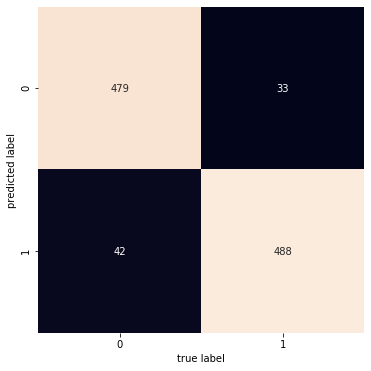

In [81]:
classes = pd.Series(labels).unique()
plt.figure(figsize=(6,6))
mat = confusion_matrix(labels, clfSVCpoly1.predict(features))
ax=sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=classes, yticklabels=classes)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.show()

In [82]:
print(classification_report(labels_test, clfSVCpoly1.predict(data_test)))

              precision    recall  f1-score   support

           0       0.78      0.73      0.75       156
           1       0.75      0.79      0.77       157

    accuracy                           0.76       313
   macro avg       0.76      0.76      0.76       313
weighted avg       0.76      0.76      0.76       313



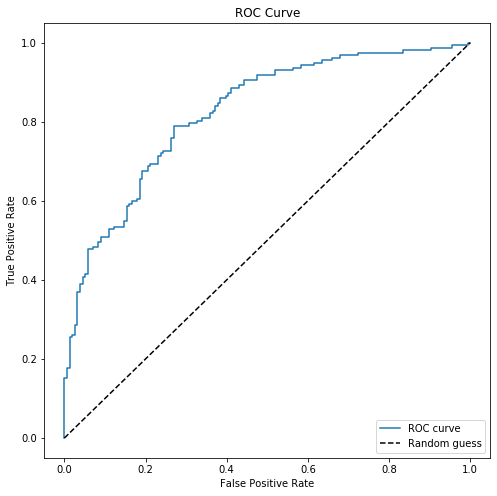

In [83]:
y_pred_prob = clfSVCpoly1.predict_proba(data_test)[:,1]

fpr, tpr, thresholds = roc_curve(labels_test, y_pred_prob)

# create plot
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')

_ = plt.legend(loc="lower right")

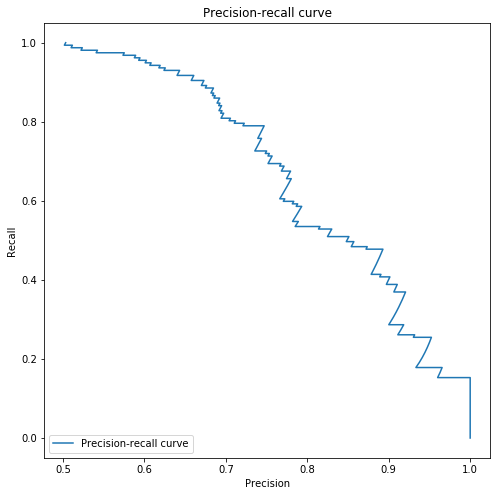

In [84]:
y_pred_prob = clfSVCpoly1.predict_proba(data_test)[:,1]

precision, recall, thresholds = precision_recall_curve(labels_test, y_pred_prob)

# create plot
plt.figure(figsize=(8, 8))
plt.plot(precision, recall, label='Precision-recall curve')
_ = plt.xlabel('Precision')
_ = plt.ylabel('Recall')
_ = plt.title('Precision-recall curve')

_ = plt.legend(loc="lower left")

# Neural Network

In [85]:
attributes = list(data_train)
attributes

['age',
 'balance',
 'housing',
 'loan',
 'duration',
 'campaign',
 'previous',
 'job_0',
 'job_1',
 'job_2',
 'job_3',
 'job_4',
 'job_5',
 'job_6',
 'job_7',
 'job_8',
 'job_9',
 'job_10',
 'job_11',
 'contact_0',
 'contact_1',
 'contact_2',
 'marital_0',
 'marital_1',
 'marital_2',
 'education_0',
 'education_1',
 'education_2',
 'education_3',
 'poutcome_0',
 'poutcome_1',
 'poutcome_2',
 'poutcome_3',
 'month_0',
 'month_1',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11',
 'day_1',
 'day_2',
 'day_3',
 'day_4',
 'day_5',
 'day_6',
 'day_7',
 'day_8',
 'day_9',
 'day_10',
 'day_11',
 'day_12',
 'day_13',
 'day_14',
 'day_15',
 'day_16',
 'day_17',
 'day_18',
 'day_19',
 'day_20',
 'day_21',
 'day_22',
 'day_23',
 'day_24',
 'day_25',
 'day_26',
 'day_27',
 'day_28',
 'day_29',
 'day_30',
 'day_31']

In [86]:
data_train[attributes]

,age,balance,housing,loan,duration,campaign,previous,job_0,job_1,job_2,...,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31
923,0.529412,0.081061,1.0,0.0,0.051013,0.000000,0.10,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
834,0.485294,0.045588,0.0,0.0,0.440666,0.172414,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
746,0.529412,0.052697,0.0,1.0,0.089363,0.103448,0.00,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
598,0.117647,0.172520,1.0,0.0,0.054993,0.034483,0.25,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
928,0.485294,0.121415,0.0,0.0,0.085745,0.034483,0.00,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,0.205882,0.045694,1.0,0.0,0.129884,0.000000,0.00,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
567,0.397059,0.063625,1.0,0.0,0.066932,0.068966,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
55,0.147059,0.059699,0.0,1.0,0.395080,0.068966,0.00,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
774,0.882353,0.057825,0.0,0.0,0.362156,0.034483,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


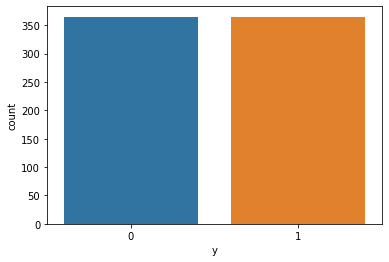

In [87]:
sns.countplot(labels_train)

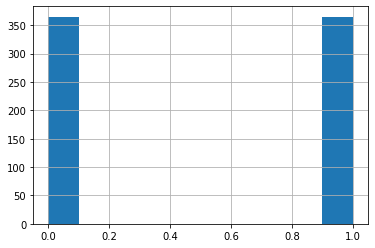

In [88]:
#Label Encoder has been adopted in the Feature Engineering above, so it is not necessary here.
labels_train.hist()

In [89]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

from tensorflow import keras

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

keras.__version__

'2.2.4-tf'

In [90]:
y = keras.utils.to_categorical(labels_train)
y

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [91]:
X = data_train[attributes].values
X

array([[0.52941176, 0.08106101, 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.48529412, 0.04558798, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.52941176, 0.05269673, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.14705882, 0.05969938, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.88235294, 0.05782493, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.26470588, 0.08024757, 1.        , ..., 0.        , 0.        ,
        1.        ]])

In [92]:
print(len(attributes))

76


In [93]:
to= time.time()
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

from tensorflow.keras import regularizers
def create_model(neurons = 76):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(neurons, input_dim=len(attributes), activation="relu"))
    model.add(keras.layers.Dense(2, activation="sigmoid"))
    model.compile(
       loss='binary_crossentropy',
       optimizer= "adam",
       metrics=['accuracy'])
    return model

         
model = keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model,epochs=5,batch_size=16)
param_grid = {
    'neurons' : [38,76],  
    'epochs': [5,10],
    'batch_size':[583]
                               }
#If no scoring is specified, the estimator passed should have a 'score' method.
clfNN = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
trainingtime.loc[0] = ["Neural Network", round((time.time()-t0), 2)] 
trainingtime.index = trainingtime.index + 1
clfNN.fit(X,y)

Train on 583 samples
Epoch 1/5
583/583 [==============================] - 1s 884us/sample - loss: 0.7489 - accuracy: 0.5026
Epoch 2/5
583/583 [==============================] - 0s 7us/sample - loss: 0.7440 - accuracy: 0.5060
Epoch 3/5
583/583 [==============================] - 0s 3us/sample - loss: 0.7393 - accuracy: 0.5094
Epoch 4/5
583/583 [==============================] - 0s 7us/sample - loss: 0.7349 - accuracy: 0.5060
Epoch 5/5
583/583 [==============================] - 0s 7us/sample - loss: 0.7306 - accuracy: 0.5120
146/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 583 samples
Epoch 1/5
583/583 [==============================] - 1s 1ms/sample - loss: 0.6974 - accuracy: 0.5172
Epoch 2/5
583/583 [==============================] - 0s 5us/sample - loss: 0.6955 - accuracy: 0.5214
Epoch 3/5
583/583 [==============================] - 0s 5us/sample - loss: 0.6937 - accuracy: 0.5266
Epoch 4/5
583/583 [==============================] - 0s 5us/sample - loss: 0.6918 - accuracy: 0.5283
Epoch 5/5
583/583 [==============================] - 0s 7us/sample - loss: 0.6900 - accuracy: 0.5334
146/1 [===================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 584 samples
Epoch 1/5
584/584 [==============================] - 0s 808us/sample - loss: 0.7064 - accuracy: 0.5026
Epoch 2/5
584/584 [==============================] - 0s 12us/sample - loss: 0.7003 - accuracy: 0.5060
Epoch 3/5
584/584 [==============================] - 0s 10us/sample - loss: 0.6958 - accuracy: 0.5137
Epoch 4/5
584/584 [==============================] - 0s 12us/sample - loss: 0.6923 - accuracy: 0.5197
Epoch 5/5
584/584 [==============================] - 0s 10us/sample - loss: 0.6898 - accuracy: 0.5265
145/1 [=============================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 583 samples
Epoch 1/5
583/583 [==============================] - 1s 1ms/sample - loss: 0.7051 - accuracy: 0.4923
Epoch 2/5
583/583 [==============================] - 0s 7us/sample - loss: 0.7018 - accuracy: 0.4983
Epoch 3/5
583/583 [==============================] - 0s 5us/sample - loss: 0.6986 - accuracy: 0.5051
Epoch 4/5
583/583 [==============================] - 0s 5us/sample - loss: 0.6956 - accuracy: 0.5111
Epoch 5/5
583/583 [==============================] - 0s 5us/sample - loss: 0.6926 - accuracy: 0.5214
146/1 [===================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 583 samples
Epoch 1/5
583/583 [==============================] - 0s 628us/sample - loss: 0.7136 - accuracy: 0.4906
Epoch 2/5
583/583 [==============================] - 0s 5us/sample - loss: 0.7088 - accuracy: 0.4966
Epoch 3/5
583/583 [==============================] - 0s 5us/sample - loss: 0.7044 - accuracy: 0.4957
Epoch 4/5
583/583 [==============================] - 0s 5us/sample - loss: 0.7004 - accuracy: 0.5077
Epoch 5/5
583/583 [==============================] - 0s 5us/sample - loss: 0.6966 - accuracy: 0.5137
146/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 583 samples
Epoch 1/10
583/583 [==============================] - 1s 1ms/sample - loss: 0.7091 - accuracy: 0.5086
Epoch 2/10
583/583 [==============================] - 0s 5us/sample - loss: 0.7056 - accuracy: 0.5146
Epoch 3/10
583/583 [==============================] - 0s 5us/sample - loss: 0.7024 - accuracy: 0.5266
Epoch 4/10
583/583 [==============================] - 0s 5us/sample - loss: 0.6992 - accuracy: 0.5309
Epoch 5/10
583/583 [==============================] - 0s 5us/sample - loss: 0.6962 - accuracy: 0.5334
Epoch 6/10
583/583 [==============================] - 0s 5us/sample - loss: 0.6933 - accuracy: 0.5334
Epoch 7/10
583/583 [==============================] - 0s 5us/sample - loss: 0.6906 - accuracy: 0.5403
Epoch 8/10
583/583 [==============================] - 0s 5us/sample - loss: 0.6880 - accuracy: 0.5472
Epoch 9/10
583/583 [==============================] - 0s 5us/sample - loss: 0.6855 - accuracy: 0.5532
Epoch 10/10
583/583 [==============================] - 0s 5us

Train on 583 samples
Epoch 1/10
583/583 [==============================] - 0s 631us/sample - loss: 0.7376 - accuracy: 0.5172
Epoch 2/10
583/583 [==============================] - 0s 5us/sample - loss: 0.7323 - accuracy: 0.5223
Epoch 3/10
583/583 [==============================] - 0s 5us/sample - loss: 0.7273 - accuracy: 0.5206
Epoch 4/10
583/583 [==============================] - 0s 5us/sample - loss: 0.7225 - accuracy: 0.5223
Epoch 5/10
583/583 [==============================] - 0s 5us/sample - loss: 0.7181 - accuracy: 0.5232
Epoch 6/10
583/583 [==============================] - 0s 5us/sample - loss: 0.7138 - accuracy: 0.5274
Epoch 7/10
583/583 [==============================] - 0s 5us/sample - loss: 0.7099 - accuracy: 0.5300
Epoch 8/10
583/583 [==============================] - 0s 5us/sample - loss: 0.7061 - accuracy: 0.5283
Epoch 9/10
583/583 [==============================] - 0s 5us/sample - loss: 0.7027 - accuracy: 0.5317
Epoch 10/10
583/583 [==============================] - 0s 3

Train on 584 samples
Epoch 1/10
584/584 [==============================] - 0s 743us/sample - loss: 0.7048 - accuracy: 0.5146
Epoch 2/10
584/584 [==============================] - 0s 12us/sample - loss: 0.6995 - accuracy: 0.5257
Epoch 3/10
584/584 [==============================] - 0s 10us/sample - loss: 0.6957 - accuracy: 0.5283
Epoch 4/10
584/584 [==============================] - 0s 9us/sample - loss: 0.6926 - accuracy: 0.5325
Epoch 5/10
584/584 [==============================] - 0s 12us/sample - loss: 0.6905 - accuracy: 0.5377
Epoch 6/10
584/584 [==============================] - 0s 10us/sample - loss: 0.6887 - accuracy: 0.5360
Epoch 7/10
584/584 [==============================] - 0s 10us/sample - loss: 0.6869 - accuracy: 0.5402
Epoch 8/10
584/584 [==============================] - 0s 10us/sample - loss: 0.6852 - accuracy: 0.5445
Epoch 9/10
584/584 [==============================] - 0s 12us/sample - loss: 0.6835 - accuracy: 0.5531
Epoch 10/10
584/584 [==============================]

Train on 583 samples
Epoch 1/10
583/583 [==============================] - 0s 672us/sample - loss: 0.7150 - accuracy: 0.4923
Epoch 2/10
583/583 [==============================] - 0s 5us/sample - loss: 0.7100 - accuracy: 0.4974
Epoch 3/10
583/583 [==============================] - 0s 5us/sample - loss: 0.7054 - accuracy: 0.5043
Epoch 4/10
583/583 [==============================] - 0s 5us/sample - loss: 0.7012 - accuracy: 0.5120
Epoch 5/10
583/583 [==============================] - 0s 5us/sample - loss: 0.6973 - accuracy: 0.5163
Epoch 6/10
583/583 [==============================] - 0s 5us/sample - loss: 0.6936 - accuracy: 0.5266
Epoch 7/10
583/583 [==============================] - 0s 5us/sample - loss: 0.6902 - accuracy: 0.5412
Epoch 8/10
583/583 [==============================] - 0s 5us/sample - loss: 0.6870 - accuracy: 0.5523
Epoch 9/10
583/583 [==============================] - 0s 5us/sample - loss: 0.6840 - accuracy: 0.5566
Epoch 10/10
583/583 [==============================] - 0s 5

Train on 583 samples
Epoch 1/10
583/583 [==============================] - 0s 635us/sample - loss: 0.6805 - accuracy: 0.5669
Epoch 2/10
583/583 [==============================] - 0s 7us/sample - loss: 0.6770 - accuracy: 0.5840
Epoch 3/10
583/583 [==============================] - 0s 5us/sample - loss: 0.6735 - accuracy: 0.5909
Epoch 4/10
583/583 [==============================] - 0s 5us/sample - loss: 0.6702 - accuracy: 0.5978
Epoch 5/10
583/583 [==============================] - 0s 7us/sample - loss: 0.6670 - accuracy: 0.5969
Epoch 6/10
583/583 [==============================] - 0s 5us/sample - loss: 0.6638 - accuracy: 0.6021
Epoch 7/10
583/583 [==============================] - 0s 3us/sample - loss: 0.6607 - accuracy: 0.6072
Epoch 8/10
583/583 [==============================] - 0s 5us/sample - loss: 0.6576 - accuracy: 0.6106
Epoch 9/10
583/583 [==============================] - 0s 5us/sample - loss: 0.6546 - accuracy: 0.6184
Epoch 10/10
583/583 [==============================] - 0s 7

Train on 729 samples
Epoch 1/10
729/729 [==============================] - 0s 640us/sample - loss: 0.7001 - accuracy: 0.5165
Epoch 2/10
729/729 [==============================] - 0s 10us/sample - loss: 0.6926 - accuracy: 0.5267
Epoch 3/10
729/729 [==============================] - 0s 10us/sample - loss: 0.6869 - accuracy: 0.5432
Epoch 4/10
729/729 [==============================] - 0s 10us/sample - loss: 0.6822 - accuracy: 0.5624
Epoch 5/10
729/729 [==============================] - 0s 10us/sample - loss: 0.6783 - accuracy: 0.5768
Epoch 6/10
729/729 [==============================] - 0s 11us/sample - loss: 0.6749 - accuracy: 0.5981
Epoch 7/10
729/729 [==============================] - 0s 10us/sample - loss: 0.6715 - accuracy: 0.5981
Epoch 8/10
729/729 [==============================] - 0s 10us/sample - loss: 0.6683 - accuracy: 0.6049
Epoch 9/10
729/729 [==============================] - 0s 10us/sample - loss: 0.6649 - accuracy: 0.6145
Epoch 10/10
729/729 [==============================

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000001A248D80108>,
             iid='warn', n_jobs=None,
             param_grid={'batch_size': [583], 'epochs': [5, 10],
                         'neurons': [38, 76]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [94]:
pd.DataFrame(clfNN.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,param_epochs,param_neurons,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.594409,0.083062,0.239162,0.002310,583,5,38,"{'batch_size': 583, 'epochs': 5, 'neurons': 38}",0.493151,0.462329,0.527397,0.513699,0.568965,0.513032,0.035464,4
1,0.586822,0.109911,0.239361,0.003155,583,5,76,"{'batch_size': 583, 'epochs': 5, 'neurons': 76}",0.578767,0.517123,0.500000,0.561644,0.537931,0.539095,0.028637,2
2,0.594011,0.117366,0.293016,0.108311,583,10,38,"{'batch_size': 583, 'epochs': 10, 'neurons': 38}",0.517123,0.510274,0.541096,0.544521,0.500000,0.522634,0.017400,3
3,0.603983,0.183656,0.239165,0.000401,583,10,76,"{'batch_size': 583, 'epochs': 10, 'neurons': 76}",0.616438,0.571918,0.568493,0.565068,0.496552,0.563786,0.038371,1


In [95]:
clfNN.best_score_

0.5637860006674491

In [96]:
params = clfNN.best_params_
params

{'batch_size': 583, 'epochs': 10, 'neurons': 76}

In [97]:
#Check whether is the best model
model1 = create_model(neurons = params["neurons"])
history = model1.fit(X,
                    y,
                    epochs=params["epochs"],
                    batch_size=params["batch_size"],
                    verbose = 0)

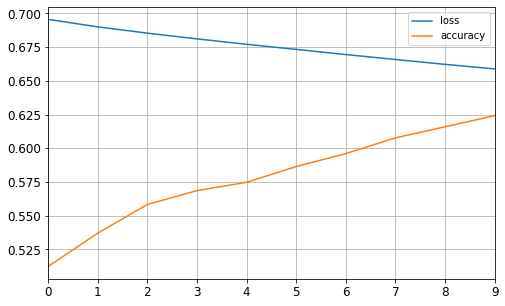

In [98]:
#Need to check whether it is Overfitting
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)

In [99]:
X_valid, X_train = X[:50], X[50:]
y_valid, y_train = y[:50], y[50:]

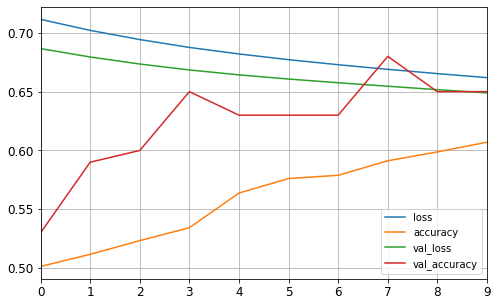

In [100]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

def create_model(neurons = 4):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(neurons, input_dim=len(attributes), activation="relu"))
    model.add(keras.layers.Dense(2, activation="sigmoid"))
    model.compile(
       loss='binary_crossentropy',
       optimizer='adam',
       metrics=["accuracy"])
    return model


model1 = create_model(neurons = params["neurons"])
history1 = model1.fit(X,
                    y, validation_data=(X_valid, y_valid),
                    epochs=params["epochs"],
                    batch_size=params["batch_size"],
                    verbose = 0)


pd.DataFrame(history1.history).plot(figsize=(8, 5))
plt.grid(True)

[0.6612277756483791, 0.6230032]

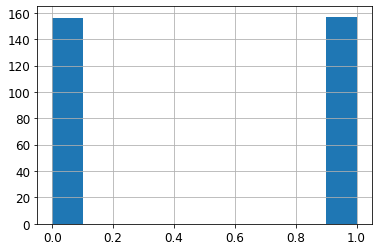

In [101]:
#Evaulation on test data
labels_test.hist()
y_testing = keras.utils.to_categorical(labels_test)
X_testing = data_test[attributes].values
model1.evaluate(X_testing, y_testing, verbose = 0)

In [102]:
X_valid, X_train = X_testing, X
y_valid, y_train = y_testing, y

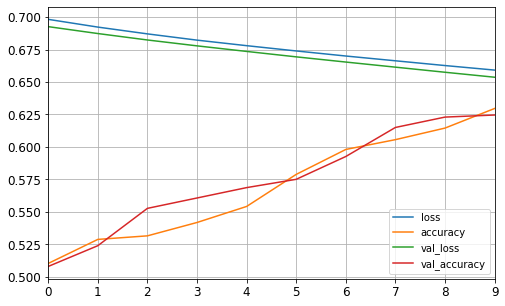

In [103]:
#Plot the whole learning curve of Neural Network
def create_model(neurons = 4):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(neurons, input_dim=len(attributes), activation="relu"))
    model.add(keras.layers.Dense(2, activation="sigmoid"))
    model.compile(
       loss='binary_crossentropy',
       optimizer="adam",
       metrics=["accuracy"])
    return model


model1 = create_model(neurons = params["neurons"])
history1 = model1.fit(X,
                    y, validation_data=(X_valid, y_valid),
                    epochs=params["epochs"],
                    batch_size=params["batch_size"],
                    verbose = 0)


pd.DataFrame(history1.history).plot(figsize=(8, 5))
plt.grid(True)

In [104]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 76)                5852      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 154       
Total params: 6,006
Trainable params: 6,006
Non-trainable params: 0
_________________________________________________________________


In [105]:
#Prepare for calculations on acc, f1, recall and precision
y_predict = model1.predict(X_testing,verbose=0)
#if y_predict > 0.5, y_predict refers to "1"
y_predict = (y_predict > 0.5).astype(int)
print(y_predict)
y_true = np.reshape(y_testing,[-1])
print(y_true)
y_pred = np.reshape(y_predict,[-1])
print(y_pred)

[[0 1]
 [1 1]
 [1 0]
 [1 1]
 [0 1]
 [1 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [1 1]
 [1 0]
 [0 1]
 [0 0]
 [1 0]
 [1 0]
 [0 1]
 [1 1]
 [1 0]
 [0 0]
 [1 0]
 [1 1]
 [0 1]
 [1 0]
 [1 0]
 [1 1]
 [1 1]
 [1 0]
 [1 1]
 [0 1]
 [0 0]
 [1 0]
 [1 1]
 [0 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 1]
 [0 1]
 [0 1]
 [1 1]
 [1 0]
 [1 1]
 [1 1]
 [1 1]
 [1 0]
 [1 0]
 [0 0]
 [1 0]
 [1 1]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 1]
 [0 1]
 [0 1]
 [1 1]
 [0 0]
 [1 0]
 [0 0]
 [0 1]
 [0 0]
 [0 1]
 [1 0]
 [1 1]
 [0 1]
 [1 1]
 [1 0]
 [0 0]
 [0 0]
 [1 0]
 [0 1]
 [1 0]
 [1 1]
 [0 0]
 [1 0]
 [1 0]
 [1 1]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 1]
 [0 1]
 [0 0]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 0]
 [0 1]
 [0 0]
 [0 1]
 [1 0]
 [1 0]
 [1 1]
 [1 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 0]
 [1 0]
 [1 0]
 [0 1]
 [0 0]
 [1 0]
 [1 1]
 [1 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 1]
 [0 0]
 [1 0]
 [1 1]

In [106]:
#Accuracy calculated by model.predict may be slightly different from accuracy calculated by model.evaluate
#beacuse model.evaluate gets a value after each batch while model.predict gets a value after k batchs

accNN = accuracy_score(y_true, y_pred)
precisionNN = precision_score(y_true, y_pred)
recallNN = recall_score(y_true,y_pred)
f1NN = f1_score(y_true, y_pred)
aucNN = roc_auc_score(y_true, y_pred)


In [107]:
print("Precision on test data is: %f" %precisionNN)
print("Recall on test data is: %f" %recallNN)
print("F1-Score on test data is: %f" %f1NN)
print("Area under ROC on test data is: %f" %aucNN)
print("Accuracy on test data is: %f" %accNN)

testing.loc[0] = ["Neural Network", precisionNN, recallNN, f1NN, aucNN, accNN]
testing.index = testing.index + 1
testing = testing.sort_index()

Precision on test data is: 0.615385
Recall on test data is: 0.664537
F1-Score on test data is: 0.639017
Area under ROC on test data is: 0.624601
Accuracy on test data is: 0.624601


# Evaluation

In [108]:
trainingtime = trainingtime.sort_values(by=['Training Time(Seconds)'])
trainingtime

,Classifier,Training Time(Seconds)
6,Gussian Naive Bayes,0.02
5,Multinomial Naive Bayes,0.08
4,Support Vector Machine-linear,1.13
8,Decision Tree,2.67
2,Support Vector Machine-poly,3.20
3,Support Vector Machine-rbf,3.51
1,Neural Network,5.63
7,Random Forest,9.12


In [109]:
testing

,Classifier,Precision,Recall,F1-Score,AUC,Accuracy
1,Neural Network,0.615385,0.664537,0.639017,0.624601,0.624601
2,Support Vector Machine-poly,0.746988,0.789809,0.767802,0.760289,0.760383
3,Support Vector Machine-rbf,0.775758,0.815287,0.795031,0.789054,0.789137
4,Support Vector Machine-linear,0.833333,0.828025,0.830671,0.830679,0.830671
5,Multinomial Naive Bayes,0.763514,0.719745,0.740984,0.747693,0.747604
6,Gussian Naive Bayes,0.885714,0.197452,0.322917,0.585906,0.584665
7,Random Forest,0.755556,0.866242,0.807122,0.792095,0.792332
8,Decision Tree,0.778523,0.738854,0.758170,0.763658,0.763578


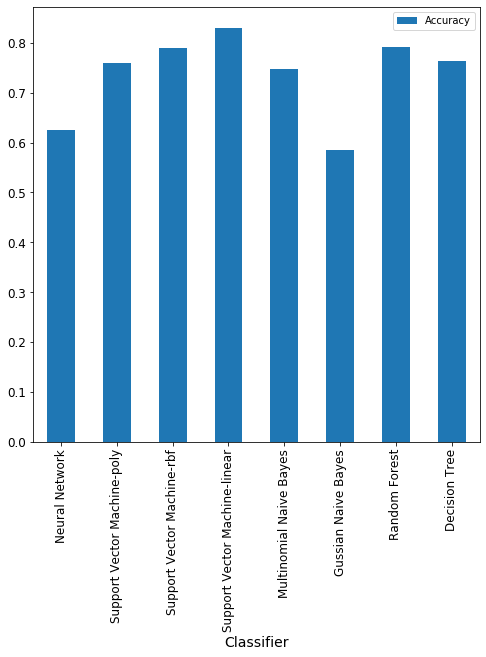

In [110]:
testing.plot.bar(x='Classifier',y=['Accuracy'],figsize=(8,8), legend=True, fontsize=12)

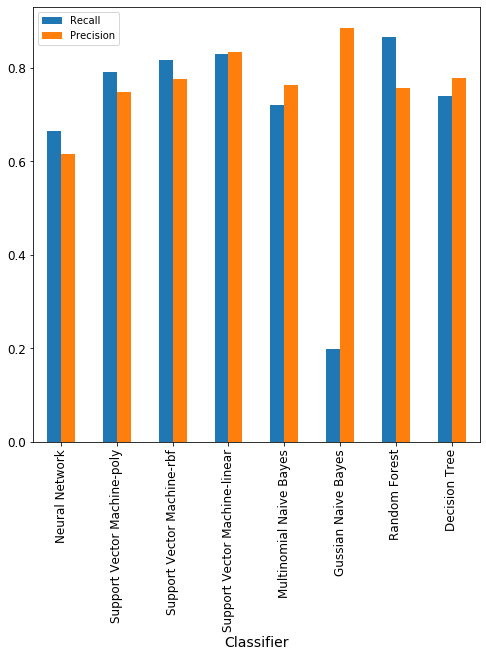

In [111]:
testing.plot.bar(x='Classifier',y=['Recall','Precision',],figsize=(8,8), legend=True, fontsize=12)

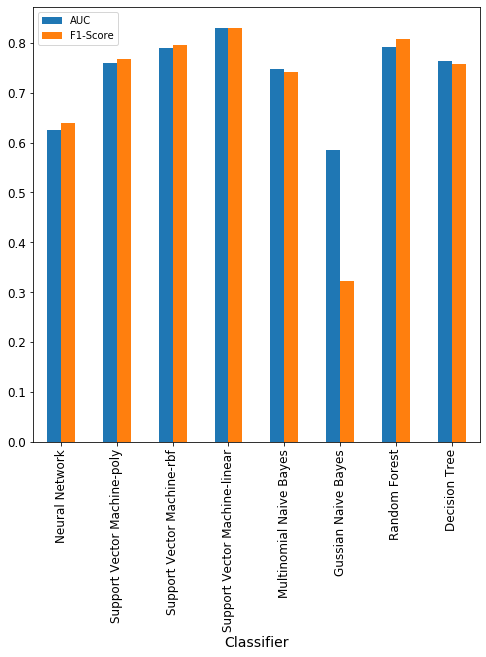

In [112]:
testing.plot.bar(x='Classifier',y=['AUC','F1-Score'],figsize=(8,8), legend=True, fontsize=12)

# Learning Curve

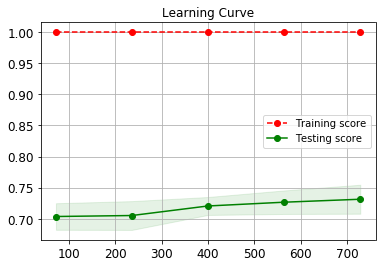

In [113]:
DT1 = DecisionTreeClassifier(random_state=90)
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=90)
from sklearn.model_selection import learning_curve
train_size, train_score, test_score = learning_curve(DT1, features, labels, cv=cv, train_sizes=np.linspace(0.1,1.0,5))
train_scores_mean = np.mean(train_score, axis=1)
train_scores_std = np.std(train_score, axis=1)
test_scores_mean = np.mean(test_score, axis=1)
test_scores_std = np.std(test_score, axis=1)
plt.fill_between(train_size, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_size, test_scores_mean - test_scores_std,test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_size, train_scores_mean,'o--', color="r",label="Training score")
plt.plot(train_size, test_scores_mean,'o-', color="g",label="Testing score")
plt.grid()
plt.title('Learning Curve')
plt.legend(loc="best")

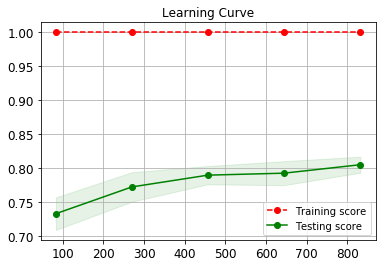

In [114]:
RF1 = RandomForestClassifier(random_state=90, n_estimators=100)
RF1.fit(data_train, labels_train)
score1 = RF1.score(data_test, labels_test)
from sklearn.model_selection import learning_curve
train_size, train_score, test_score = learning_curve(RF1, features, labels, cv=5, train_sizes=np.linspace(0.1,1.0,5))
train_scores_mean = np.mean(train_score, axis=1)
train_scores_std = np.std(train_score, axis=1)
test_scores_mean = np.mean(test_score, axis=1)
test_scores_std = np.std(test_score, axis=1)
plt.fill_between(train_size, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_size, test_scores_mean - test_scores_std,test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_size, train_scores_mean,'o--', color="r",label="Training score")
plt.plot(train_size, test_scores_mean,'o-', color="g",label="Testing score")
plt.grid()
plt.title('Learning Curve')
plt.legend(loc="best")


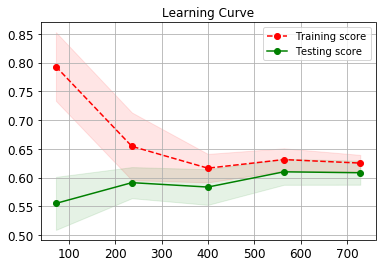

In [115]:
GNB1 = GaussianNB()
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=90)
from sklearn.model_selection import learning_curve
train_size, train_score, test_score = learning_curve(GNB1, features, labels, cv=cv, train_sizes=np.linspace(0.1,1.0,5))
train_scores_mean = np.mean(train_score, axis=1)
train_scores_std = np.std(train_score, axis=1)
test_scores_mean = np.mean(test_score, axis=1)
test_scores_std = np.std(test_score, axis=1)
plt.fill_between(train_size, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_size, test_scores_mean - test_scores_std,test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_size, train_scores_mean,'o--', color="r",label="Training score")
plt.plot(train_size, test_scores_mean,'o-', color="g",label="Testing score")
plt.grid()
plt.title('Learning Curve')
plt.legend(loc="best")

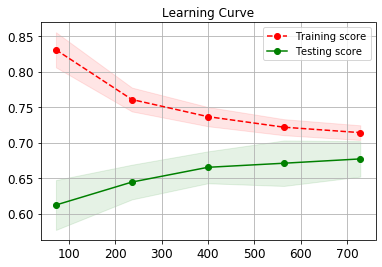

In [116]:
MNB1 = MultinomialNB()
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=90)
from sklearn.model_selection import learning_curve
train_size, train_score, test_score = learning_curve(MNB1, features, labels, cv=cv, train_sizes=np.linspace(0.1,1.0,5))
train_scores_mean = np.mean(train_score, axis=1)
train_scores_std = np.std(train_score, axis=1)
test_scores_mean = np.mean(test_score, axis=1)
test_scores_std = np.std(test_score, axis=1)
plt.fill_between(train_size, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_size, test_scores_mean - test_scores_std,test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_size, train_scores_mean,'o--', color="r",label="Training score")
plt.plot(train_size, test_scores_mean,'o-', color="g",label="Testing score")
plt.grid()
plt.title('Learning Curve')
plt.legend(loc="best")

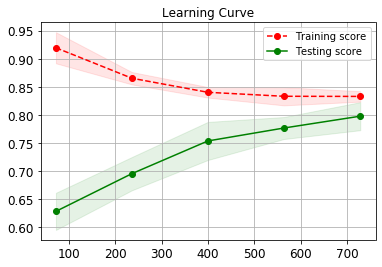

In [117]:
SVClinear1 = SVC(kernel="linear")
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=90)
from sklearn.model_selection import learning_curve
train_size, train_score, test_score = learning_curve(SVC(kernel="linear"), features, labels, cv=cv, train_sizes=np.linspace(0.1,1.0,5))
train_scores_mean = np.mean(train_score, axis=1)
train_scores_std = np.std(train_score, axis=1)
test_scores_mean = np.mean(test_score, axis=1)
test_scores_std = np.std(test_score, axis=1)
plt.fill_between(train_size, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_size, test_scores_mean - test_scores_std,test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_size, train_scores_mean,'o--', color="r",label="Training score")
plt.plot(train_size, test_scores_mean,'o-', color="g",label="Testing score")
plt.grid()
plt.title('Learning Curve')
plt.legend(loc="best")

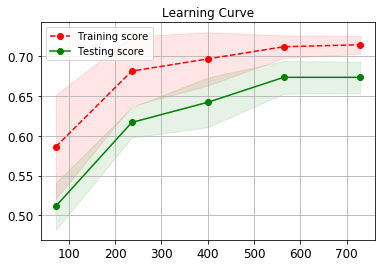

In [118]:
SVCrbf1 = SVC(kernel="rbf", gamma="auto")
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=90)
from sklearn.model_selection import learning_curve
train_size, train_score, test_score = learning_curve(SVCrbf1, features, labels, cv=cv, train_sizes=np.linspace(0.1,1.0,5))
train_scores_mean = np.mean(train_score, axis=1)
train_scores_std = np.std(train_score, axis=1)
test_scores_mean = np.mean(test_score, axis=1)
test_scores_std = np.std(test_score, axis=1)
plt.fill_between(train_size, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_size, test_scores_mean - test_scores_std,test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_size, train_scores_mean,'o--', color="r",label="Training score")
plt.plot(train_size, test_scores_mean,'o-', color="g",label="Testing score")
plt.grid()
plt.title('Learning Curve')
plt.legend(loc="best")

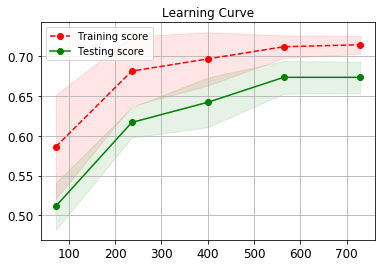

In [119]:
SVCpoly1 = SVC(kernel="rbf",gamma="auto")
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=90)
from sklearn.model_selection import learning_curve
train_size, train_score, test_score = learning_curve(SVCpoly1, features, labels, cv=cv, train_sizes=np.linspace(0.1,1.0,5))
train_scores_mean = np.mean(train_score, axis=1)
train_scores_std = np.std(train_score, axis=1)
test_scores_mean = np.mean(test_score, axis=1)
test_scores_std = np.std(test_score, axis=1)
plt.fill_between(train_size, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_size, test_scores_mean - test_scores_std,test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_size, train_scores_mean,'o--', color="r",label="Training score")
plt.plot(train_size, test_scores_mean,'o-', color="g",label="Testing score")
plt.grid()
plt.title('Learning Curve')
plt.legend(loc="best")

In [120]:
#The learning cruve of Neural Network has displayed before the Evualtion cell.